In [1]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev

In [2]:
def phase_fit(phi, A, B, C, phi_0):
    return A * np.cos(phi - phi_0) +  B * phi + C

def get_phase_fitter(phases, heights, height_errs):
    fitter = Fitter(phase_fit)
    fitter.set_data(phases, heights, height_errs)
    fitter.set_bounds("A", 0, np.inf)

    # setting this bound makes weird fits for certain phi_0's because they want to fit to a value outside the bound
    # fitter.set_bounds("phi_0", 0, 2*np.pi)
    fitter.fit()
    return fitter

In [3]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [4]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    detunings_MHz = header["detunings"].to("MHz").magnitude
    transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
    monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
    normalized_avg = {}
    for kk in transmissions_avg:
        if transmissions_avg[kk].ndim >= 1:
            normalized_avg[kk] = unumpy.uarray(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
        else:
            normalized_avg[kk] = ufloat(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
    return detunings_MHz, normalized_avg, header

In [5]:
def get_experiment_result(data_number):
    detunings, data, header = get_normalized_transmission(data_number)
    total_pop_1 = 1#data["1"] - data["2"]
    pop_other_state_1 = -data["3"]#data["1"] - data["3"]
    total_pop_2 = 1#data["4"] - data["5"]
    pop_other_state_2 = -data["6"]#data["4"] - data["6"]
    # print(total_pop_1, total_pop_2)
    return (header, pop_other_state_1 + pop_other_state_2, total_pop_1 + total_pop_2)

In [6]:
def get_results(data_identification):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, pop_other_state, total_pop = get_experiment_result(data_number)
        headers.append(header)
        results.append(pop_other_state / total_pop)
    return headers, np.array(results)

In [7]:
def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std

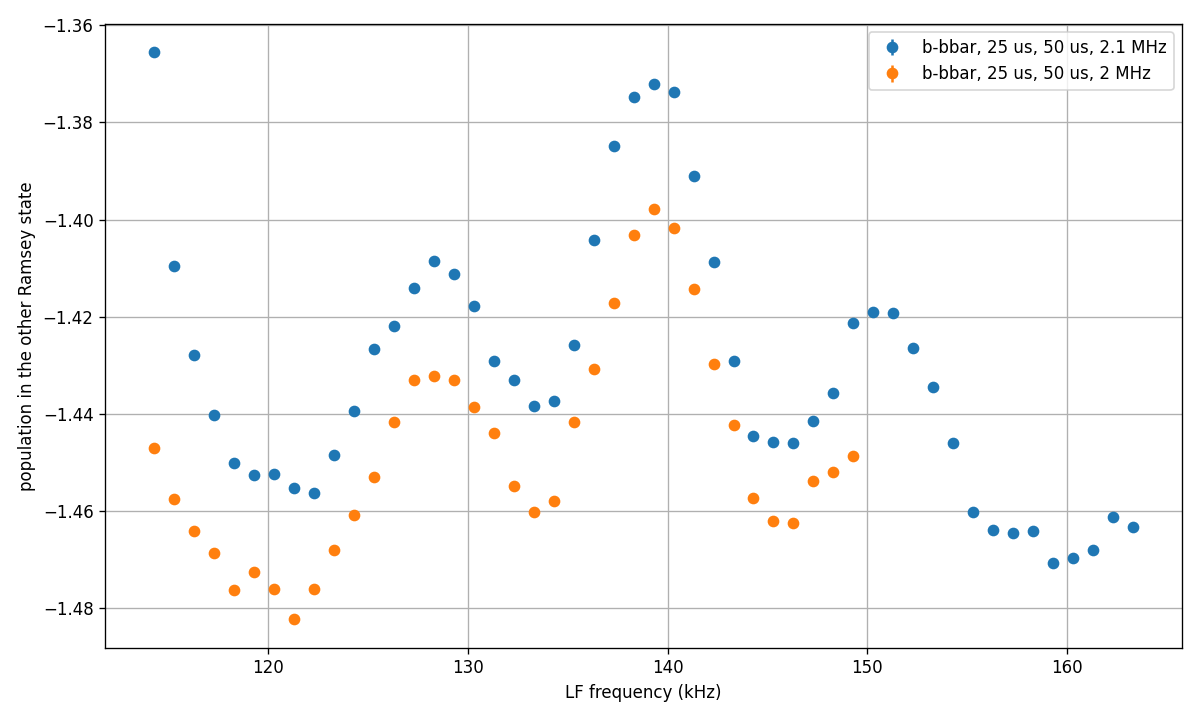

In [8]:
data = {
    # "a-abar, 90 us, 90 us": (978080, 978109),
    # "b-bbar, 25 us, 50 us": (985461, 985510),
    # "a-b, 5000, 100 us": (1031448, 1031647),
    "b-bbar, 25 us, 50 us, 2.1 MHz": (1036477, 1036526),
    "b-bbar, 25 us, 50 us, 2 MHz": (1036570, 1036605),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results_temp = get_results(data_range)
    xs = [(header["params"]["lf"]["detunings"][0] + header["params"]["lf"]["center_frequencies"][0]).to("kHz").magnitude for header in headers]
    if results_temp.ndim == 1:
        ys = unumpy.nominal_values(results_temp)
        errs = unumpy.std_devs(results_temp)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(1):
            ys = unumpy.nominal_values(results_temp[:, kk])
            errs = unumpy.std_devs(results_temp[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel("LF frequency (kHz)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [9]:
d,h = get_experiment_data(1625324)  # (1625324, 1625332)
h["temp"]

14.2929

In [10]:
1552306 + 17 * 50, 1552322 + 17 * 99

(1553156, 1554005)

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
temp
A = 0.011(3) 
B = -0.0016(11) 
C = -9.504(4) 
phi_0 = 0.4(3) 
temp
A = 0.016(2) 
B = 0.0007(10) 
C = -9.246(4) 
phi_0 = 0.29(19) 


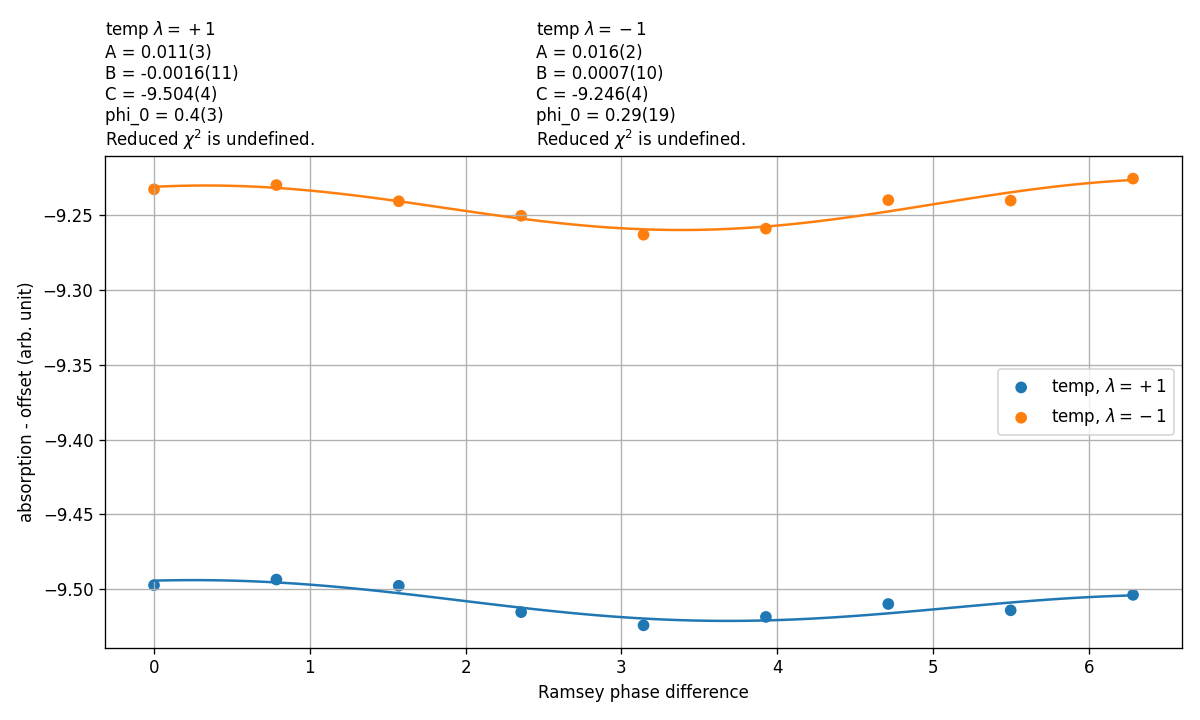

SNR with 9 phase points = 7.150179059045659


In [11]:
do_average = True

data = {
    "temp": (1737111, 1737119),
}

index = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results_temp = get_results(data_range)
    mask = np.ones(len(headers), dtype=bool)
    for kk, header in enumerate(headers):
        sequence = header["params"]["sequence"]["sequence"]
        if header["params"]["field_plate"]["amplitude"] < 0:
            mask[kk] = True
        for name, repeat in sequence:
            if name.startswith("lf"):
                index.append(int(name.split("_")[-1]))
                break
    xs = np.array([header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)])
    print(xs[:17] / np.pi * 4)
    if results_temp.ndim == 1:
        ys = unumpy.nominal_values(results_temp)
        errs = unumpy.std_devs(results_temp)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(0, 2):
            ys = unumpy.nominal_values(results_temp[:, kk])
            errs = unumpy.std_devs(results_temp[:, kk])
            if do_average:
                xs_avg, ys_avg, errs_avg = averaging_ys(xs[mask], ys[mask])
            else:
                xs_avg, ys_avg, errs_avg = xs, ys, errs
            if kk == 0:
                lambda_label = ", $\\lambda = +1$"
            else:
                lambda_label = ", $\\lambda = -1$"
            ax.scatter(xs_avg, ys_avg, label=label + lambda_label, marker='o', linestyle='')
            fitter = get_phase_fitter(xs_avg, ys_avg, None)
            xs_fit = np.linspace(np.min(xs_avg), np.max(xs_avg), 100)
            ys_fit = fitter.fitted_value(xs_fit)
            ax.plot(xs_fit, ys_fit)
            if kk == 0:
                label_str = label + " $\\lambda = +1$ \n" + fitter.all_results_str()
                ax.text(0,1.02, label_str, transform = ax.transAxes)
            else:
                label_str = label + " $\\lambda = -1$ \n" + fitter.all_results_str()
                ax.text(0.4,1.02, label_str, transform = ax.transAxes)
            print(label)
            print(fitter.result_str("A"))
            print(fitter.result_str("B"))
            print(fitter.result_str("C"))
            print(fitter.result_str("phi_0"))

ax.set_xlabel("Ramsey phase difference")
ax.set_ylabel("absorption - offset (arb. unit)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
print(f"SNR with 9 phase points = {fitter.results["A"]/fitter.errors["A"]}")

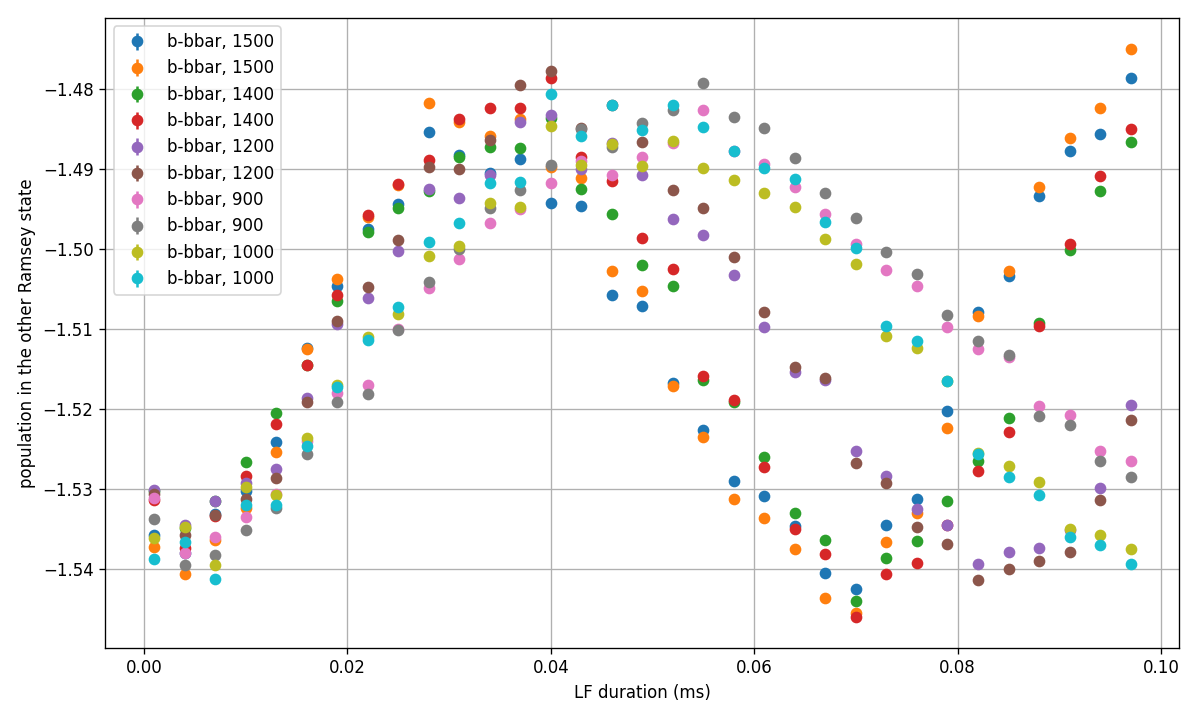

In [1839]:
data = {
    "b-bbar, 1500": (985296, 985328),
    "b-bbar, 1400": (985329, 985361),
    "b-bbar, 1200": (985362, 985394),
    "b-bbar, 900": (985395, 985427),
    "b-bbar, 1000": (985428, 985460),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results_temp = get_results(data_range)
    xs = [(header["params"]["lf"]["durations"][0]).to("ms").magnitude for header in headers]
    if results_temp.ndim == 1:
        ys = unumpy.nominal_values(results_temp)
        errs = unumpy.std_devs(results_temp)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(2):
            ys = unumpy.nominal_values(results_temp[:, kk])
            errs = unumpy.std_devs(results_temp[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## long term phase scan

In [13]:
import onix.models.hyperfine as hyperfine
magnetic_field = 223e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(magnetic_field)
e_g, s_g = ground.energies_and_eigenstates()

a_I_dot_n = (s_g[0].dag() * ground._I_x * s_g[0]).tr()
abar_I_dot_n = (s_g[1].dag() * ground._I_x * s_g[1]).tr()
b_I_dot_n = (s_g[2].dag() * ground._I_x * s_g[2]).tr()
bbar_I_dot_n = (s_g[3].dag() * ground._I_x * s_g[3]).tr()
I_a = (abar_I_dot_n - a_I_dot_n) / 2
I_b = (bbar_I_dot_n - b_I_dot_n) / 2

def combine_polarization_data(results):
    def check_equal_and_append(check_from, check_name, append_to):
        check_col = check_from[:, col_indices[check_name]]
        count = np.unique(check_col)
        if len(count) > 1:
            raise Exception(f"{check_name} is not the same.")
        append_to.append(check_col[0])

    results_array = pandas.DataFrame.from_dict(results).to_numpy()
    keys = list(results.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = {
        "f+": [],
        "f-": [],
        "start_time": [],
        "end_time": [],
        "temp": [],
    }
    for kk in range(len(results_array) // 2):
        sub_data = results_array[kk * 2: kk * 2 + 2]
        data_indices = []
        for name in results.keys():
            if name not in ["start_time", "end_time", "D", "freq_center", "temp"]:
                if name not in data:
                    data[name] = []
                check_equal_and_append(sub_data, name, data[name])
        for ll, datapoint in enumerate(sub_data):
            if ll == 0:
                start_time = datapoint[col_indices["start_time"]]
            if ll == len(sub_data) - 1:
                end_time = datapoint[col_indices["end_time"]]
            if datapoint[col_indices["D"]]:
                f_p = datapoint[col_indices["freq_center"]]
            else:
                f_m = datapoint[col_indices["freq_center"]]

        data["f+"].append(f_p)
        data["f-"].append(f_m)
        data["start_time"].append(start_time)
        data["end_time"].append(end_time)
        data["temp"].append(np.nanmean(sub_data[:, col_indices["temp"]]))

    data["f+"] = np.array(data["f+"])
    data["f-"] = np.array(data["f-"])
    data["Z"] = (data["f+"] + data["f-"]) / 4
    data["W_T"] = []
    for kk in range(len(data["f+"])):
        if data["state"][kk] == "a":
            I = I_a
        else:
            I = I_b
        data["W_T"].append((data["f+"][kk] - data["f-"][kk]) / 4 / I)

    keys = list(data.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = pandas.DataFrame.from_dict(data).to_numpy()
    return data, col_indices

In [59]:
analysis_dnum = 613

In [99]:
loaded_data["col_indices"]

array({'f+': 0, 'f-': 1, 'start_time': 2, 'end_time': 3, 'temp': 4, 'lf_center_freq': 5, 'state': 6, 'E': 7, 'field_plate_amplitude': 8, 'electric_field_shift_MHz': 9, 'pulse_time_ms': 10, 'wait_time_ms': 11, 'Z': 12, 'W_T': 13},
      dtype=object)

In [244]:
# detect detunings
#data_range = (1737936, 1737944)
#max = 1744235

# temperature scan
# data_range = (1571153, 1571153+8)
# max = 1624846

# carrier frequency scan 1
# data_range = (1555028, 1555034)
# max = 1557043

# carrier frequency scan 2
# data_range = (1557099+90, 1557107+90)
# max = 1565792

# with rigol TTLed for field plate trigger
data_range = (1746176+80*9, 1746184+80*9)
max = 1756786

points_per_scan = data_range[1] - data_range[0]
first = data_range[0]
last = max
first_unprocessed = first
all_old_data = False

loaded_data = None
path_to_save = get_analysis_file_path(analysis_dnum, f"{first}_{last}_processed.npz")
dir = os.path.dirname(path_to_save)
for file in os.listdir(dir):
    start_str, stop_str, _ = file.split("_")
    start = int(start_str)
    stop = int(stop_str)
    if start == data_range[0]:
        if stop == max:
            all_old_data = True
        first_unprocessed = stop + 1
        old_data_path = os.path.join(dir, file)
        loaded_data = np.load(old_data_path, allow_pickle = True)
        print("existing data loaded")
        break
    

current = first_unprocessed + points_per_scan
offset = 0
all_results = {
    "lf_center_freq": [],
    "freq_center": [],
    "state": [],
    "E": [],
    "D": [],
    "field_plate_amplitude": [],
    "electric_field_shift_MHz": [],
    "pulse_time_ms": [],
    "wait_time_ms": [],
    "start_time": [],
    "end_time": [],
    "detect_detuning_MHz": [],
    "temp": [],
}

heights = []
diff_heights = []

t1 = time.time()

if all_old_data is False:
    while current + offset <= max:
        data_range_now = (first_unprocessed + offset, first_unprocessed + points_per_scan + offset)
        data_list = data_identification_to_list(data_range_now)
        headers, results = get_results(data_range_now)
    
        for header in headers:
            if "temp" not in header or header["temp"] is None:
                header["temp"] = np.nan
    
        index = []
        for header in headers:
            sequence = header["params"]["sequence"]["sequence"]
            for name, repeat in sequence:
                if name.startswith("lf"):
                    index.append(int(name.split("_")[-1]))
                    break
                    
        center_freq = headers[0]["params"]["lf"]["center_frequencies"][index[0]].to("Hz").magnitude
        pulse_time_ms = headers[0]["params"]["lf"]["durations"][0].to("ms").magnitude
        wait_time_ms = headers[0]["params"]["lf"]["wait_times"][0].to("ms").magnitude
        total_time_ms = pulse_time_ms + wait_time_ms
        detuning = headers[0]["params"]["lf"]["detunings"][0].to("Hz").magnitude
        probe_freq = center_freq + detuning
        fp_amplitude = headers[0]["params"]["field_plate"]["amplitude"]
        stark_shift = headers[0]["params"]["field_plate"]["stark_shift"].to("MHz").magnitude
        detect_detuning = headers[0]["params"]["detect"]["detunings"].to("MHz").magnitude
        E_field = fp_amplitude > 0
        phases = [header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)]
        temp = np.nanmean([header["temp"] for header in headers])
    
    
        for kk in range(2):  # positive and negative Stark components.
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            fitter = get_phase_fitter(phases, ys, None)
            phi0 = ufloat(fitter.results["phi_0"], fitter.errors["phi_0"])
            phi0 = (np.pi + phi0) % (2 * np.pi) - np.pi
            freq_center = phi0 / (2 * np.pi) / (total_time_ms * 1e-3) + probe_freq
            
            neg_DdotE = kk == 0
            E = E_field
            D = (not neg_DdotE) == E
            epoch_times = (
                headers[0]["data_info"]["save_epoch_time"],
                headers[-1]["data_info"]["save_epoch_time"],
            )
            if probe_freq > 200e3:
                state = "a"
            else:
                state = "b"
            all_results["lf_center_freq"].append(center_freq)
            all_results["freq_center"].append(freq_center)
            all_results["state"].append(state)
            all_results["E"].append(E)
            all_results["D"].append(D)
            all_results["start_time"].append(epoch_times[0])
            all_results["end_time"].append(epoch_times[1])
            all_results["pulse_time_ms"].append(pulse_time_ms)
            all_results["wait_time_ms"].append(wait_time_ms)
            all_results["field_plate_amplitude"].append(fp_amplitude)
            all_results["electric_field_shift_MHz"].append(stark_shift)
            all_results["detect_detuning_MHz"].append(detect_detuning)
            all_results["temp"].append(temp)
    
            heights.append(ys)
        if E_field:
            diff_heights.append(heights[-1] - heights[-2])
        else:
            diff_heights.append(heights[-2] - heights[-1])
        offset += len(list(data_list))
    new_results, col_indices = combine_polarization_data(all_results)

    if loaded_data is None:
        results = new_results
    else:
        results = np.concatenate((loaded_data["results"], new_results), axis = 0)

    try:
        os.remove(old_data_path)
    except:
        pass
    np.savez(
            path_to_save,
            results=results,
            col_indices=col_indices,
        )

else:
    results = loaded_data["results"]
    

print(np.average(np.std(heights, axis=0)))
print(np.average(np.std(diff_heights, axis=0)))

existing data loaded
0.028034956347285526
0.04996060944065699


In [245]:
a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]


# temp1 = np.logical_and(results[:, col_indices["temp"]] >= 6.54 , results[:, col_indices["temp"]] <= 6.6)
# temp2 = np.logical_and(results[:, col_indices["temp"]] > 6.95 , results[:, col_indices["temp"]] <= 7.1)
# temp3 = np.logical_and(results[:, col_indices["temp"]] > 7.5 , results[:, col_indices["temp"]] <= 7.6)
# temp4 = np.logical_and(results[:, col_indices["temp"]] > 8.2 , results[:, col_indices["temp"]] <= 8.3)
# temp5 = np.logical_and(results[:, col_indices["temp"]] > 9 , results[:, col_indices["temp"]] <= 9.1)
# temp6 = np.logical_and(results[:, col_indices["temp"]] > 9.77 , results[:, col_indices["temp"]] <= 9.85)
# temp7 = np.logical_and(results[:, col_indices["temp"]] > 10.45 , results[:, col_indices["temp"]] <= 10.55)
# temp8 = np.logical_and(results[:, col_indices["temp"]] > 11.04 , results[:, col_indices["temp"]] <= 11.1)
# temp9 = np.logical_and(results[:, col_indices["temp"]] > 11.96 , results[:, col_indices["temp"]] <= 12)
# temp10 = np.logical_and(results[:, col_indices["temp"]] > 12.42 , results[:, col_indices["temp"]] <= 12.47)
# temp11 = np.logical_and(results[:, col_indices["temp"]] > 12.89 , results[:, col_indices["temp"]] <= 12.93)
# temp12 = np.logical_and(results[:, col_indices["temp"]] > 13.35 , results[:, col_indices["temp"]] <= 13.425)
# temp13 = np.logical_and(results[:, col_indices["temp"]] > 14.25 , results[:, col_indices["temp"]] <= 14.3)
# temp_masks = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11, temp12, temp13]

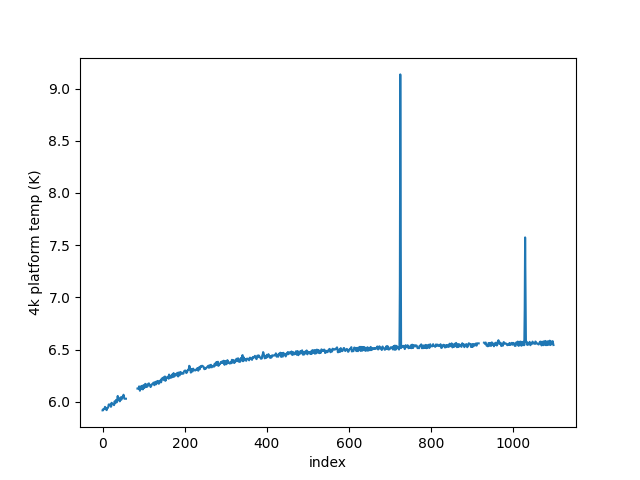

In [246]:
fig, ax = plt.subplots()
ax.plot(results[:, col_indices["temp"]])

ax.set_xlabel("index")
ax.set_ylabel("4k platform temp (K)");

In [247]:
all_results["start_time"][2] - all_results["start_time"][0]

4.099017143249512

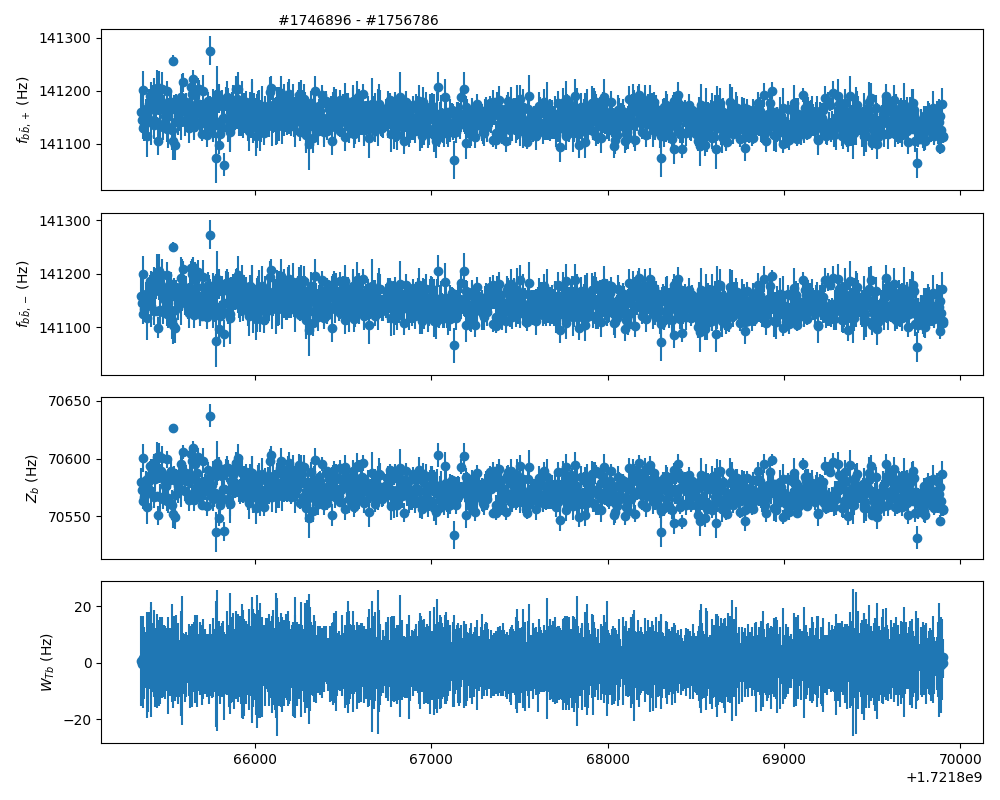

f_b,+ = 141147.0(7) Hz
f_b,- = 141145.7(7) Hz
Δf(b; D=±1 ,E=+1) = 0.33(5) Hz
Δf(b; D=±1 ,E=-1) = 0.56(6) Hz
W_T_b = 0.45(4) Hz


In [248]:
errorbar_args = {"fmt": "o", "ls": "none"}

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    for kk, d in enumerate(
        [
            results[mask, col_indices["f+"]],
            results[mask, col_indices["f-"]],
            results[mask, col_indices["Z"]],
            results[mask, col_indices["W_T"]]
        ]
    ):
        axs[kk * len(masks) + ll].errorbar(
            results[mask, col_indices["start_time"]], unumpy.nominal_values(d), unumpy.std_devs(d),
            **errorbar_args
        )
axs[0].text(0.2, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()
if "a" in masks:
    mask = masks["a"]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    print("f_a,+ =", present_float(np.average(unumpy.nominal_values(f_p_a)), np.average(np.std(unumpy.nominal_values(f_p_a))) / np.sqrt(len(f_p_a))), "Hz")
    print("f_a,- =", present_float(np.average(unumpy.nominal_values(f_m_a)), np.average(np.std(unumpy.nominal_values(f_m_a))) / np.sqrt(len(f_m_a))), "Hz")
    print("Δf(a; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_a[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_a[E_pos]))) / np.sqrt(len(W_T_a[E_pos]))), "Hz")
    print("Δf(a; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_a[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_a[E_neg]))) / np.sqrt(len(W_T_a[E_neg]))), "Hz")
if "b" in masks:
    mask = masks["b"]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
    print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
    print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
    print("Δf(b; D=±1 ,E=-1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_b[E_neg]))) / np.sqrt(len(W_T_b[E_neg]))), "Hz")
    print("W_T_b =", present_float(np.average(unumpy.nominal_values(W_T_b)), np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))), "Hz")

In [242]:
duration = np.max(results[:, col_indices["start_time"]]) - np.min(results[:, col_indices["start_time"]])
print(f'#{first} - #{last}')
print(duration)
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))
duration = np.max(results[mask, col_indices["start_time"]]) - np.min(results[mask, col_indices["start_time"]])
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("Δf(b; D=±1 ,E=-1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_b[E_neg]))) / np.sqrt(len(W_T_b[E_neg]))), "Hz")

#1746896 - #1755427
3922.6196229457855
0.059 Hz sqrt(hr)
f_b,+ = 141148.1(8) Hz
f_b,- = 141146.7(8) Hz
W_T = 0.462(44) Hz
Δf(b; D=±1 ,E=+1) = 0.35(6) Hz
Δf(b; D=±1 ,E=-1) = 0.57(6) Hz


/tmp/ipykernel_413825/1006897818.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(x, ds[0], yerr = ers[0], label="$D = +1, E = +1$", fmt="o", ls="", alpha=0.5, marker = ".")
/tmp/ipykernel_413825/1006897818.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(x, ds[1], yerr = ers[1], label="$D = -1, E = +1$", fmt="o", ls="", alpha=0.5, marker = "v")
/tmp/ipykernel_413825/1006897818.py:43: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(x, ds[2], yerr = ers[2], label="$D = +1, E = -1$", fmt="o", ls="", alpha=0.5, marker = "^")
/tmp/ipykernel_413825/1006897818.py:44: UserWarning: marker is redundantl

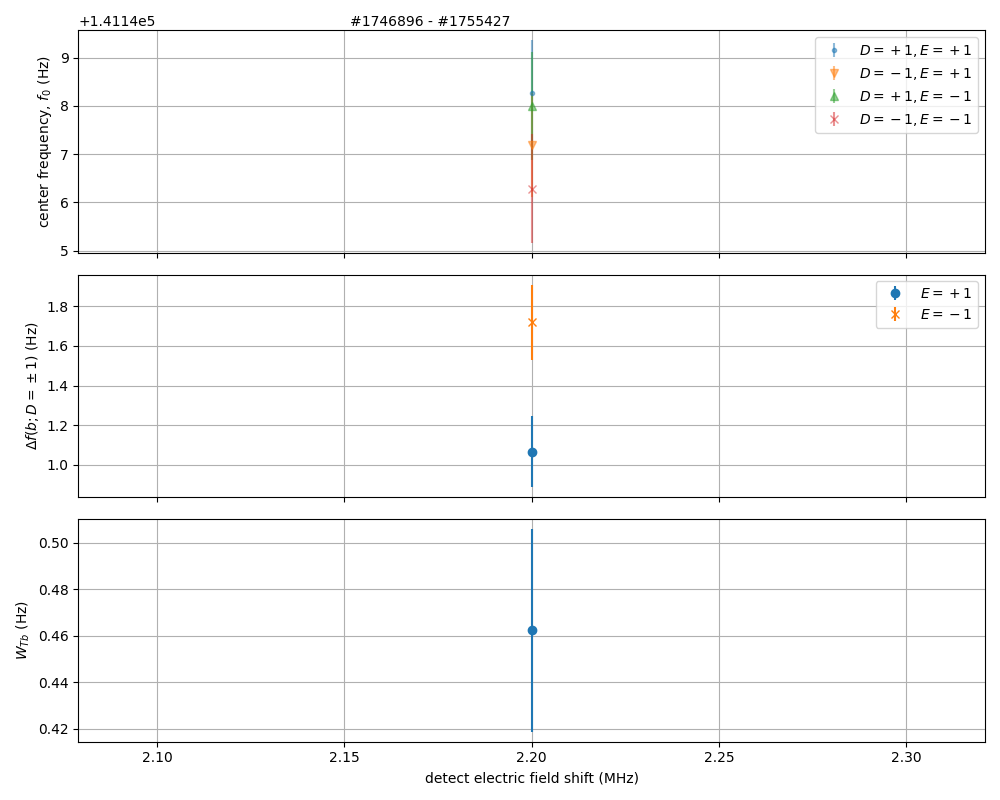

In [243]:
plot_label = "electric_field_shift_MHz"
x_label = "detect electric field shift (MHz)"
take_absolute = False
col = results[:, col_indices[plot_label]]
if take_absolute:
    col = abs(col)
x = np.unique(col)
x_masks = []
for x_value in x:
    x_masks.append(col == x_value)

# plot_label = "Temperate Scan"
# x_label = "4 K Platform Temperature (K)"

# x = []
# x_std = []
# for mask in temp_masks:
#     val = np.mean(results[mask, col_indices["temp"]])
#     std = np.std(results[mask, col_indices["temp"]])
#     x.append(val)
#     x_std.append(std)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ds = []
ers = []
for EE in [E_pos_mask, E_neg_mask]:
    for ff in ["f+", "f-"]:
        d = []
        er = []
        for kk in range(len(x)):
            frequencies = results[b_mask&EE&x_masks[kk], col_indices[ff]]
            nom = unumpy.nominal_values(frequencies)
            unc = unumpy.std_devs(frequencies)
            d.append(np.average(nom))
            er.append(np.average(unc)/np.sqrt(len(unc)))
            
        ds.append(d)
        ers.append(er)

axs[0].errorbar(x, ds[0], yerr = ers[0], label="$D = +1, E = +1$", fmt="o", ls="", alpha=0.5, marker = ".")
axs[0].errorbar(x, ds[1], yerr = ers[1], label="$D = -1, E = +1$", fmt="o", ls="", alpha=0.5, marker = "v")
axs[0].errorbar(x, ds[2], yerr = ers[2], label="$D = +1, E = -1$", fmt="o", ls="", alpha=0.5, marker = "^")
axs[0].errorbar(x, ds[3], yerr = ers[3], label="$D = -1, E = -1$", fmt="o", ls="", alpha=0.5, marker = "x")
axs[0].grid()
axs[0].legend()

W_T_temp = []
W_T_temp_err = []

delta_f_temp_E_pos = []
delta_f_temp_E_pos_err = []

delta_f_temp_E_neg = []
delta_f_temp_E_neg_err = []

for mask in x_masks:
    W_T = unumpy.nominal_values(results[mask, col_indices["W_T"]])
    delta_f_E_pos = unumpy.nominal_values(results[mask&E_pos_mask, col_indices["f+"]] - results[mask&E_pos_mask, col_indices["f-"]])
    delta_f_E_neg = unumpy.nominal_values(results[mask&E_neg_mask, col_indices["f+"]] - results[mask&E_neg_mask, col_indices["f-"]])
    
    W_T_temp.append(np.average(W_T))
    delta_f_temp_E_pos.append(np.average(delta_f_E_pos))
    delta_f_temp_E_neg.append(np.average(delta_f_E_neg))
                           
    W_T_temp_err.append(np.std(W_T) / np.sqrt(len(W_T)))
    delta_f_temp_E_pos_err.append(np.std(delta_f_E_pos) / np.sqrt(len(delta_f_E_pos)))
    delta_f_temp_E_neg_err.append(np.std(delta_f_E_neg) / np.sqrt(len(delta_f_E_neg)))

axs[1].errorbar(x, delta_f_temp_E_pos, yerr = delta_f_temp_E_pos_err, label = "$E = +1$", fmt = "o", ls="")
axs[1].errorbar(x, delta_f_temp_E_neg, yerr = delta_f_temp_E_neg_err, label = "$E = -1$", fmt = "o", ls="", marker = "x")
axs[1].grid()
axs[1].legend()

axs[2].errorbar(x, W_T_temp, yerr = W_T_temp_err, fmt="o", ls="", label = "")
axs[2].grid()

axs[0].set_ylabel("center frequency, $f_0$ (Hz)")
axs[1].set_ylabel("$\\Delta f(b; D = \\pm 1)$ (Hz)")
axs[2].set_ylabel("$W_{Tb}$ (Hz)")
axs[2].set_xlabel(x_label)

axs[0].text(.3, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
#print(f"N_total = {(max-data_range[0]+1)}")
#print(f"N_meas = {(max-data_range[0]+1)/(5*2*9)}")
#print(f"Expected delta_f = {367/np.sqrt(max-data_range[0]+1)} Hz")
plt.tight_layout()
plt.savefig("carrier_freq_scan.pdf")
plt.show()